action: [-1, -0.5, 0, 0.5, 1]

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import optimizers, losses
from tensorflow.keras import Model

from collections import deque
import random
import datetime
import math

from tqdm import tqdm

from typing import Final


In [3]:
fData = pd.read_csv('./2018.10.31.01.00-2018.12.01.09.00_소비전력.csv')

fData['timestamp'] = pd.to_datetime(fData['timestamp'])

fData.set_index('timestamp', inplace=True)
fData

,electric_energy_consumption(Wh)
timestamp,
2018-10-31 00:01:00,288.0
2018-10-31 00:02:00,272.0
2018-10-31 00:03:00,288.0
2018-10-31 00:04:00,240.0
2018-10-31 00:05:00,288.0
...,...
2018-12-01 08:56:00,112.0
2018-12-01 08:57:00,96.0
2018-12-01 08:58:00,112.0


In [4]:
month_total = fData.iloc[:1440*30].sum()[0] / 1000
contract = month_total / 15 / 30
contract

C:\Users\hansung\AppData\Local\Temp\ipykernel_20656\1582787509.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  month_total = fData.iloc[:1440*30].sum()[0] / 1000


26.811128888888888

In [5]:
# for i, row in fData.iterrows():
#     fData.loc[i] /= 1000
    
# fData.rename(columns = {'electric_energy_consumption(Wh)':'real_consumption(kWh)'}, inplace=True)
# fData


<Axes: xlabel='timestamp'>

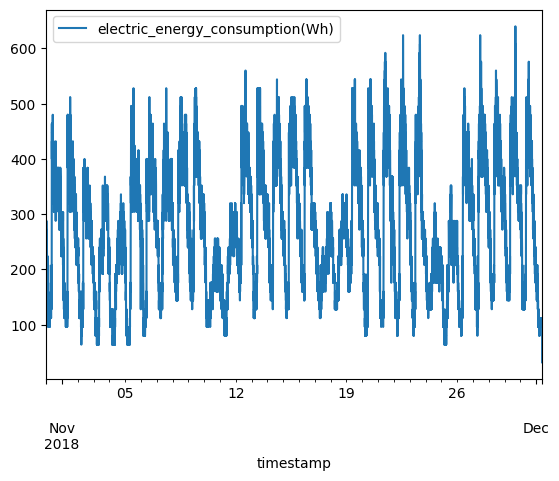

In [6]:
# fData = fData[1:]
fData.plot()


In [7]:
class Network(Model):
    def __init__(self, state_size: int, action_size: int, hidden_size: int
    ):
        super(Network, self).__init__()
        
        self.layer1 = tf.keras.layers.Dense(hidden_size, activation='relu')
        self.layer2 = tf.keras.layers.Dense(hidden_size, activation='relu')
        self.value = tf.keras.layers.Dense(action_size)

    def call(self, state):
        layer1 = self.layer1(state)
        layer2 = self.layer2(layer1)
        value = self.value(layer2)
        return value

In [8]:
class DQNAgent:
    def __init__(
        self, 
        batch_size: int,
        target_update: int,
        hidden_size: int,
        predict_len: int,
        consumption_gap: int
    ):
        # TOU parameters(원/kWh)
        self.LOW_LOAD: Final = 98.1
        self.MIDDLE_LOAD: Final = 128.5
        self.HIGH_LOAD: Final = 143.3

        # battery parameters
        self.BATTERY_CAPACITY: Final = 1000000 #wh
        self.MIN_SOC: Final = 10
        self.MAX_SOC: Final = 90
        self.MAX_BATTERY_POWER: Final = self.BATTERY_CAPACITY / 2
        self.EFFICIENCY: Final = 0.9

        self.CONSUMPTION_GAP: Final = consumption_gap

        # network parameters
        self.state_size: Final = 4 + predict_len * 2
        self.action_space: Final = [-64, -32, -16, -8, -4, -2, -1, -0.5, 0, 0.5, 1, 2, 4, 8, 16, 32, 64]
        self.action_size: Final = len(self.action_space)
        self.hidden_size: Final = hidden_size

        # hyper parameters
        self.lr: Final = 0.001
        self.gamma: Final = 0.95
        self.target_update: Final = target_update
        self.predict_len: Final = predict_len

        # replay memory
        self.memory = deque(maxlen=2000)
        self.batch_size: Final = batch_size

        self.dqn = Network(
            self.state_size, self.action_size, hidden_size
        )
        self.dqn_target = Network(
            self.state_size, self.action_size, hidden_size
        )
        
        self.optimizers = optimizers.Adam(learning_rate=self.lr, )
        
        self.target_hard_update()

    def initialize_episode(self, data):
        self.set_data(data)
        self.set_threshold()

    def set_threshold(self):
        self.threshold = 400
        # DAY_UNIT = 60 * 24

        # if len(self.data) < DAY_UNIT:
        #     self.threshold = self.data.max()[0] * 0.8
        # else :
        #     sum = 0
        #     for i in range(DAY_UNIT, len(self.data)+1, DAY_UNIT):
        #         sum += self.data[i-DAY_UNIT: i].max()[0]

        #     self.threshold = (sum / (len(self.data) // DAY_UNIT)) * 0.8

    def set_data(self, data):
        self.data = data

    def get_tou(self, timestmap : pd.Timestamp): # only winter
        if timestmap.hour >= 22 or timestmap.hour <= 7 : 
            return self.LOW_LOAD
        elif (timestmap.hour >= 9 and timestmap.hour <= 11) or (timestmap.hour >= 16 and timestmap.hour <= 18) : 
            return self.HIGH_LOAD
        else :
            return self.MIDDLE_LOAD

    def target_hard_update(self):
        self.dqn_target.set_weights(self.dqn.get_weights())

    def append_sample(self, state, action, reward, next_state):
        self.memory.append((state, action, reward, next_state))
        
        
    def get_action(self, state, epsilon):
        
        if np.random.rand() <= epsilon:
            action = np.random.choice(self.action_size)
        else:
            q_value = self.dqn(tf.convert_to_tensor([state], dtype=tf.float32))[0]
            action = np.argmax(q_value) 

        return action
    
    def take_step(self, state, action, step_num):
        
        #[SoC, battery power, power consumption_1, tou_1, pc_2, tou_2, pc3, tou_3, pc4,tou_4]

        next_state = [state[0]]
        # battery power
        next_state.append(state[1] + self.action_space[action])

        # power consumption
        next_state.append(self.data.iloc[step_num, 0])
        next_state.append(self.get_tou(self.data.iloc[step_num].name))

        # SoC
        next_state[0] += (next_state[1] / self.BATTERY_CAPACITY) * 100 * self.EFFICIENCY

        # predicted consumptions
        for i in range(self.predict_len):
            next_state.append(self.data.iloc[step_num + 1 + i, 0])
            next_state.append(self.get_tou(self.data.iloc[step_num + 1 + i].name))

        reward = self.__get_reward(state, next_state, action)

        return next_state, reward

    def normal_distribution_function(self, x, mean = 0, sigma = 1) :
        return math.pow(math.e, -math.pow(x - mean, 2) / (2 * (sigma ** 2)))
    
    def stepwise_function(self, x, end) :
        if x <= 0:
            return 0

        if end <= 0:
            return -x
        

        if x <= end :
            return x / end
        else :
            return -math.log(x - end)

    def __get_reward(self, prev_state, next_state, action_idx):
        #[SoC, battery power, power consumption_1, tou_1, pc_2, tou_2, pc3, tou_3, pc4,tou_4]
        
        MAX_REWARD = 1e5
        MAX_PENALTY = -1e5

        prev_soc = prev_state[0]
        prev_battery_power = prev_state[1]
        prev_consumption = prev_state[2]
        prev_tou = prev_state[3]
    
        next_soc = next_state[0]
        next_battery_power = next_state[1]
        next_consumption = next_state[2]
        next_tou = next_state[3]

        action = self.action_space[action_idx]
        max_action = max(self.action_space)

        if (abs(prev_battery_power) >= self.MAX_BATTERY_POWER and action >= 0) \
            or (prev_soc <= self.MIN_SOC and action <= 0) \
                or (prev_soc >= self.MAX_SOC and action >= 0):
            return MAX_PENALTY
        
        if next_consumption > self.threshold:
            if prev_battery_power > 0:
                if action >= 0:
                    return MAX_PENALTY
                elif next_battery_power >= 0: # action < 0
                    return MAX_REWARD * abs(action) / max_action
                else : # action < 0 and next_battery_power < 0
                    target = next_consumption - self.threshold + next_battery_power
                    if target > 0:
                        return MAX_REWARD * abs(action) / max_action
                    elif target == 0:
                        return MAX_REWARD
                    else:
                        return MAX_PENALTY
            
            elif prev_battery_power == 0:
                if action >= 0:
                    return MAX_PENALTY
                
                # action < 0 and next_battery_power < 0
                target = next_consumption - self.threshold + next_battery_power
                if target > 0:
                    return MAX_REWARD * abs(action) / max_action
                elif target == 0:
                    return MAX_REWARD
                else:
                    return MAX_PENALTY

            else : # prev_battery_power < 0
                if next_battery_power >= 0:
                    return MAX_PENALTY

                # next_battery_power < 0
                target = next_consumption - self.threshold + next_battery_power
                if target > 0:
                    if action < 0:
                        return MAX_REWARD * abs(action) / max_action
                    else :
                        return MAX_PENALTY
                elif target == 0:
                    return MAX_REWARD
                else:
                    if action <= 0:
                        return MAX_PENALTY
                    else:
                        return MAX_REWARD
                
        #endif next_consumption > self.threshold:
        elif next_tou == self.LOW_LOAD:
            if prev_soc < 60:
                target = (60.0 - prev_soc) / 100.0 * self.BATTERY_CAPACITY - next_battery_power * self.EFFICIENCY

                if prev_battery_power > 0:
                    if next_battery_power <= 0:
                        return MAX_PENALTY
                    
                    if target > 0 :
                        return MAX_REWARD * action / max_action
                    elif target == 0 :
                        return MAX_REWARD
                    else :
                        if action >= 0:
                            return MAX_PENALTY
                        else :
                            return MAX_REWARD
                else:
                    if action <= 0 :
                        return MAX_PENALTY
                    
                    if target > 0 : # action > 0
                        return MAX_REWARD * action / max_action
                    elif target == 0 :
                        return MAX_REWARD
                    else :
                        return MAX_PENALTY
            #if prev_soc >= 60:        
            else : # 배터리 파워가 0에 가까워질수록 보상
                if prev_battery_power >= 0 and next_battery_power >= 0 : #prev_battery_power + action >= 0:
                    if action >= 0 :
                        return MAX_PENALTY
                    else :
                        return MAX_REWARD
                # elif prev_battery_power >= 0 and next_battery_power < 0 : 
                #     if action >= 0 :  조건 개선 필요
                #         return MAX_PENALTY
                #     else :
                #         return MAX_REWARD
                # elif prev_battery_power < 0 and next_battery_power > 0 :    
                #     if action >= 0 :
                #         return MAX_PENALTY
                #     else :
                #         return MAX_REWARD
                # else :
                #     if action <= 0 :
                #         return MAX_PENALTY
                #     else :
                #         return MAX_REWARD

                elif prev_battery_power < 0 and next_battery_power < 0 :    
                    if action <= 0 :
                        return MAX_PENALTY
                    else :
                        return MAX_REWARD
                else :
                    return MAX_REWARD
                    
                
        # endif next_tou == self.LOW_LOAD:      
        else : # 배터리 파워가 0에 가까워질수록 보상
            if prev_battery_power >= 0 and next_battery_power >= 0 : #prev_battery_power + action >= 0:
                    if action >= 0 :
                        return MAX_PENALTY
                    else :
                        return MAX_REWARD
                # elif prev_battery_power >= 0 and next_battery_power < 0 : 
                #     if action >= 0 :  조건 개선 필요
                #         return MAX_PENALTY
                #     else :
                #         return MAX_REWARD
                # elif prev_battery_power < 0 and next_battery_power > 0 :    
                #     if action >= 0 :
                #         return MAX_PENALTY
                #     else :
                #         return MAX_REWARD
                # else :
                #     if action <= 0 :
                #         return MAX_PENALTY
                #     else :
                #         return MAX_REWARD

            elif prev_battery_power < 0 and next_battery_power < 0 :    
                if action <= 0 :
                    return MAX_PENALTY
                else :
                    return MAX_REWARD
            else :
                return MAX_REWARD


    def train_step(self):
        mini_batch = random.sample(self.memory, self.batch_size)

        states      = [[i[0]] for i in mini_batch]
        actions     = [i[1] for i in mini_batch]
        rewards     = [i[2] for i in mini_batch]
        next_states = [[i[3]] for i in mini_batch]
        
        dqn_variable = self.dqn.trainable_variables
        with tf.GradientTape() as tape:
            tape.watch(dqn_variable)
            
            states      = tf.convert_to_tensor(np.vstack(states), dtype=tf.float32)
            actions     = tf.convert_to_tensor(actions, dtype=tf.int32)
            rewards     = tf.convert_to_tensor(rewards, dtype=tf.float32)
            next_states = tf.convert_to_tensor(np.vstack(next_states), dtype=tf.float32)
            
            curr_Qs    = self.dqn(states)
            main_value = tf.reduce_sum(tf.one_hot(actions, self.action_size) * curr_Qs, axis=1)

            next_Qtargets = self.dqn_target(next_states)
            next_action = tf.argmax(next_Qtargets, axis=1)
            target_value = tf.reduce_sum(tf.one_hot(next_action, self.action_size) * next_Qtargets, axis=1)

            error = tf.square(main_value - (rewards + self.gamma * target_value)) * 0.5
            loss  = tf.reduce_mean(error)
            
        dqn_grads = tape.gradient(loss, dqn_variable)
        self.optimizers.apply_gradients(zip(dqn_grads, dqn_variable))

In [9]:
train_df = fData[:int(len(fData) * 0.9)]
test_df = fData[int(len(fData) * 0.9):]

In [10]:
2*(train_df.max()[0] - train_df.min()[0]) - (train_df.max()[0] - train_df.min()[0])

C:\Users\hansung\AppData\Local\Temp\ipykernel_20656\2035781946.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  2*(train_df.max()[0] - train_df.min()[0]) - (train_df.max()[0] - train_df.min()[0])


560.0

In [11]:
# hyper parameters
hidden_size = 64
max_episodes = 10000
batch_size = 64
max_steps = 100

target_update = 10
update_cnt = 0

predict_len = 3

consumption_gap = train_df.max()[0] - train_df.min()[0]

# Exploration parameters
epsilon = 1.0                 
max_epsilon = 1.0             
min_epsilon = 0.01            
decay_rate = 0.005            


agent = DQNAgent(
    batch_size,
    target_update,
    hidden_size,
    predict_len,
    consumption_gap
)


scores = []

# for episode in tqdm(range(max_episodes), desc='episode', position=0, leave=True):
with tqdm(range(max_episodes)) as tr:
    for episode in tr:
        #initial value [SoC, battery power, power consumption_1, tou_1, power consumption_2, tou_2, pc3, tou_3, pc4,tou_4]
        start_num = int((len(train_df) - max_steps - predict_len - 1) * np.random.rand())

        state = [np.random.rand() * 80 + 10, 2 * consumption_gap * np.random.rand() - consumption_gap,\
                  train_df.iloc[start_num,0], agent.get_tou(train_df.iloc[start_num].name)]
        
        for i in range(predict_len):
            state.append(train_df.iloc[start_num + 1 + i,0])
            state.append(agent.get_tou(train_df.iloc[start_num + 1 + i].name))

        agent.initialize_episode(train_df[start_num : start_num + max_steps + predict_len + 1])
        
        episode_reward = 0
        #for step in tqdm(range(1, max_steps + 1), desc='step', position=1, leave=False):
        for step in range(1, max_steps + 1):
            action = agent.get_action(state, epsilon)
            
            next_state, reward = agent.take_step(state, action, step)
            agent.append_sample(state, action, reward, next_state)
            
            state = next_state

            episode_reward += reward

            if len(agent.memory) >= agent.batch_size:
                agent.train_step()
                update_cnt += 1

                if update_cnt % agent.target_update == 0 :
                    agent.target_hard_update()
            
        epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_rate*episode) 
           
        scores.append(episode_reward)
        tr.set_postfix(reward=f'{episode_reward}')

C:\Users\hansung\AppData\Local\Temp\ipykernel_20656\1195285898.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  consumption_gap = train_df.max()[0] - train_df.min()[0]
100%|██████████| 10000/10000 [3:47:27<00:00,  1.36s/it, reward=7800000.0]   


In [12]:
agent.dqn.save_weights('q-net_10_19')
agent.dqn_target.save_weights('q-net_19')

<Axes: >

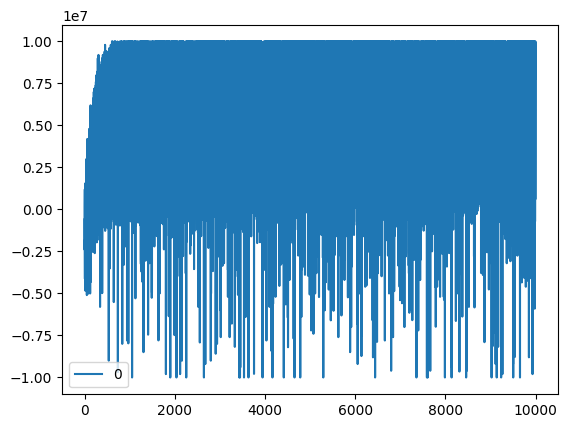

In [13]:
pd.DataFrame(scores).plot()

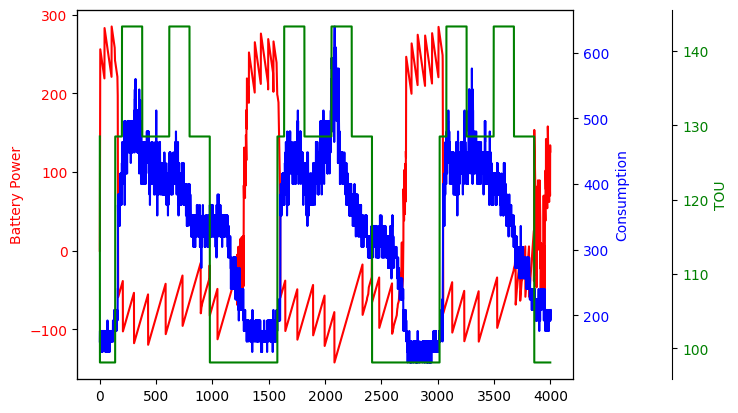

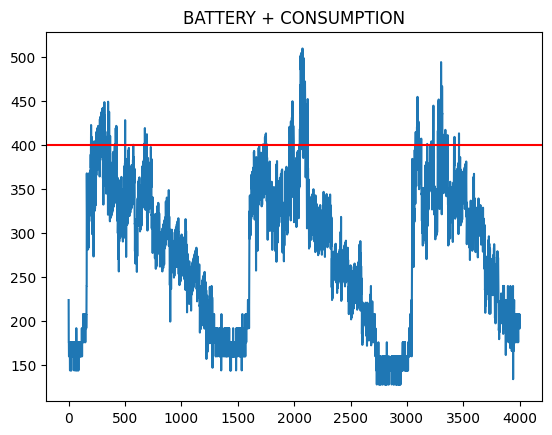

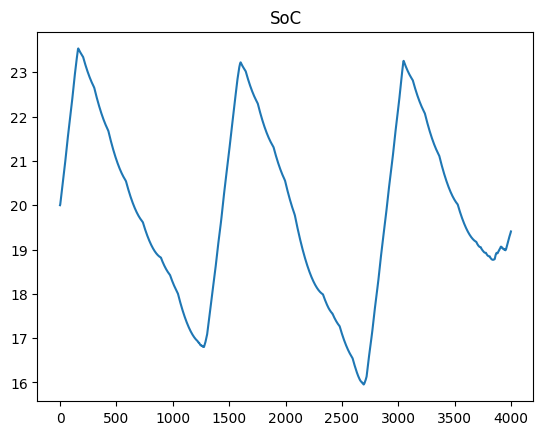

In [18]:
simulation_len = 4000

# agent.initialize_episode(test_df[:simulation_len])
agent.set_data(test_df[:simulation_len + predict_len + 1])
agent.set_threshold()

state = [20, 0, train_df.iloc[start_num,0], agent.get_tou(train_df.iloc[start_num].name)]
# state = [1, agent.battery_capacity * 0.05, agent.data.iloc[0,0]]
for i in range(predict_len):
    state.append(agent.data.iloc[i+1, 0])
    state.append(agent.get_tou(agent.data.iloc[i+1].name))

#[SoC, battery power, power consumption_1, tou_1, power consumption_2, tou_2, pc3, tou_3, pc4,tou_4]

powers = [state[1]]
SoCs = [state[0]] 
net_loads = [state[1] + state[2]]
tous = [state[3]]
for step in range(1, simulation_len):
    q_value = agent.dqn(tf.convert_to_tensor([state], dtype=tf.float32))[0]
    action = np.argmax(q_value) 

    next_state, reward = agent.take_step(state, action, step) 
    
    state = next_state
    powers.append(state[1])
    SoCs.append(state[0])
    net_loads.append( min(state[1],0) + state[2])
    tous.append(state[3])

# df = pd.DataFrame({'timestamp' : pd.date_range(test_df[:simulation_len].index[0] + datetime.timedelta(minutes=1), freq='T', periods = simulation_len, tz = None),
#                     'power(kW)' : powers})
# df.set_index('timestamp', inplace=True)

fig, ax1 = plt.subplots()
color1 = 'red'
ax1.plot(powers, color = color1)
ax1.set_ylabel('Battery Power', color = color1, rotation = 90)
ax1.tick_params(axis='y', labelcolor=color1)

ax2 = ax1.twinx();
color2 = 'blue'
ax2.plot(agent.data.values.flatten(), color = color2)
ax2.set_ylabel('Consumption', color = color2, rotation = 90)
ax2.tick_params(axis='y', labelcolor=color2)

ax3 = ax1.twinx()
color3 = 'green'
ax3.plot(tous, color = color3)
ax3.set_ylabel('TOU', color = color3, rotation = 90)
ax3.tick_params(axis='y', labelcolor=color3)
ax3.spines.right.set_position(('axes', 1.2))
plt.show()

plt.title("BATTERY + CONSUMPTION")
plt.plot(pd.DataFrame({'Net_Load' : net_loads}))
plt.axhline(agent.threshold, color='r')
plt.show()

plt.title("SoC")
plt.plot(pd.DataFrame({'SoC' : SoCs}))
plt.show()

    

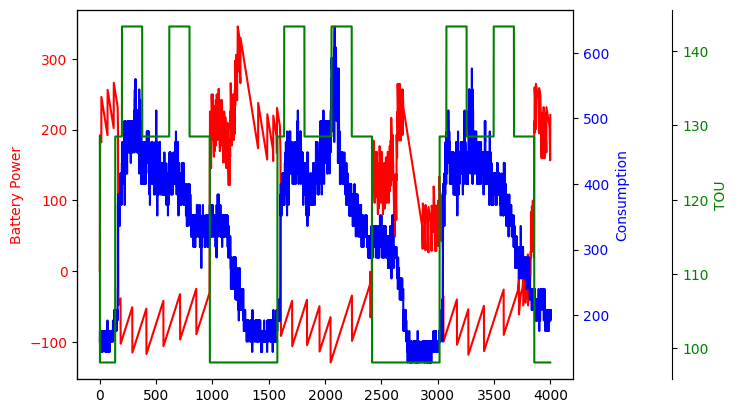

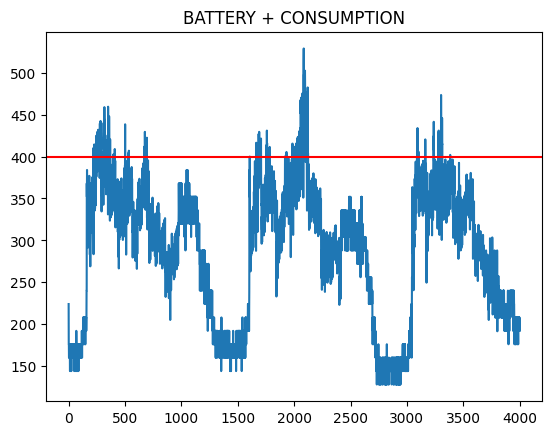

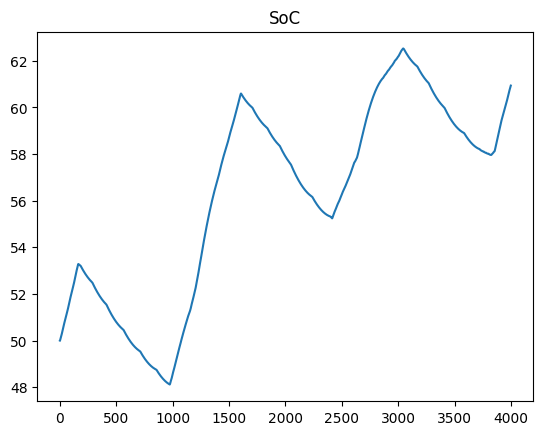

In [17]:
simulation_len = 4000

# agent.initialize_episode(test_df[:simulation_len])
agent.set_data(test_df[:simulation_len + predict_len + 1])
agent.set_threshold()

state = [50, 0, train_df.iloc[start_num,0], agent.get_tou(train_df.iloc[start_num].name)]
# state = [1, agent.battery_capacity * 0.05, agent.data.iloc[0,0]]
for i in range(predict_len):
    state.append(agent.data.iloc[i+1, 0])
    state.append(agent.get_tou(agent.data.iloc[i+1].name))

#[SoC, battery power, power consumption_1, tou_1, power consumption_2, tou_2, pc3, tou_3, pc4,tou_4]

powers = [state[1]]
SoCs = [state[0]] 
net_loads = [state[1] + state[2]]
tous = [state[3]]
for step in range(1, simulation_len):
    q_value = agent.dqn(tf.convert_to_tensor([state], dtype=tf.float32))[0]
    action = np.argmax(q_value) 

    next_state, reward = agent.take_step(state, action, step) 
    
    state = next_state
    powers.append(state[1])
    SoCs.append(state[0])
    net_loads.append( min(state[1],0) + state[2])
    tous.append(state[3])

# df = pd.DataFrame({'timestamp' : pd.date_range(test_df[:simulation_len].index[0] + datetime.timedelta(minutes=1), freq='T', periods = simulation_len, tz = None),
#                     'power(kW)' : powers})
# df.set_index('timestamp', inplace=True)

fig, ax1 = plt.subplots()
color1 = 'red'
ax1.plot(powers, color = color1)
ax1.set_ylabel('Battery Power', color = color1, rotation = 90)
ax1.tick_params(axis='y', labelcolor=color1)

ax2 = ax1.twinx();
color2 = 'blue'
ax2.plot(agent.data.values.flatten(), color = color2)
ax2.set_ylabel('Consumption', color = color2, rotation = 90)
ax2.tick_params(axis='y', labelcolor=color2)

ax3 = ax1.twinx()
color3 = 'green'
ax3.plot(tous, color = color3)
ax3.set_ylabel('TOU', color = color3, rotation = 90)
ax3.tick_params(axis='y', labelcolor=color3)
ax3.spines.right.set_position(('axes', 1.2))
plt.show()

plt.title("BATTERY + CONSUMPTION")
plt.plot(pd.DataFrame({'Net_Load' : net_loads}))
plt.axhline(agent.threshold, color='r')
plt.show()

plt.title("SoC")
plt.plot(pd.DataFrame({'SoC' : SoCs}))
plt.show()

    

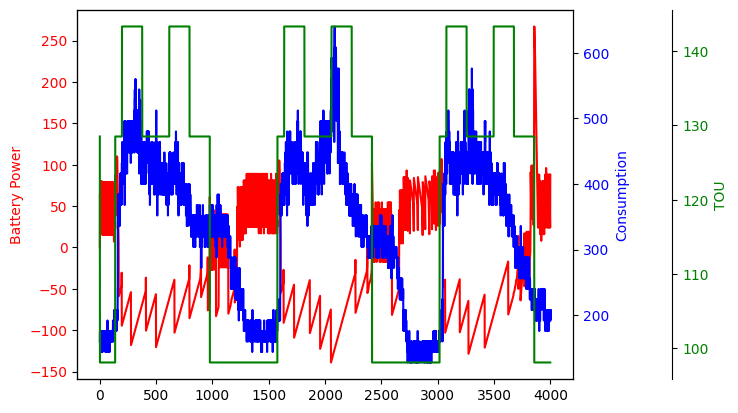

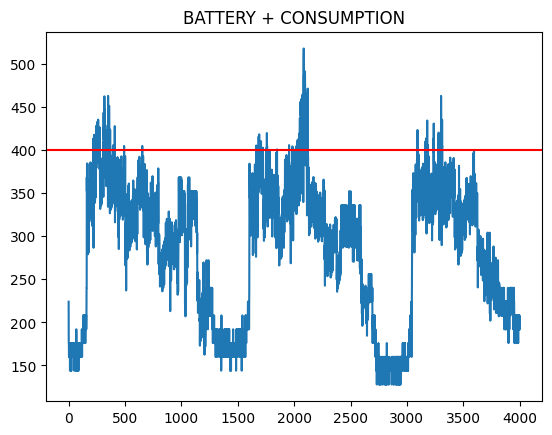

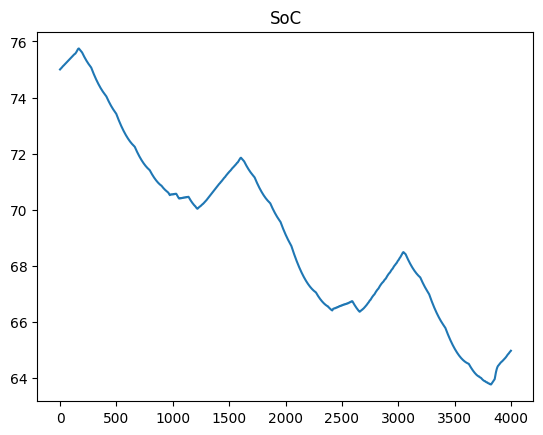

In [16]:
simulation_len = 4000

# agent.initialize_episode(test_df[:simulation_len])
agent.set_data(test_df[:simulation_len + predict_len + 1])
agent.set_threshold()

state = [75, 0, train_df.iloc[start_num,0], agent.get_tou(train_df.iloc[start_num].name)]
# state = [1, agent.battery_capacity * 0.05, agent.data.iloc[0,0]]
for i in range(predict_len):
    state.append(agent.data.iloc[i+1, 0])
    state.append(agent.get_tou(agent.data.iloc[i+1].name))

#[SoC, battery power, power consumption_1, tou_1, power consumption_2, tou_2, pc3, tou_3, pc4,tou_4]

powers = [state[1]]
SoCs = [state[0]] 
net_loads = [state[1] + state[2]]
tous = [state[3]]
for step in range(1, simulation_len):
    q_value = agent.dqn(tf.convert_to_tensor([state], dtype=tf.float32))[0]
    action = np.argmax(q_value) 

    next_state, reward = agent.take_step(state, action, step) 
    
    state = next_state
    powers.append(state[1])
    SoCs.append(state[0])
    net_loads.append( min(state[1],0) + state[2])
    tous.append(state[3])

# df = pd.DataFrame({'timestamp' : pd.date_range(test_df[:simulation_len].index[0] + datetime.timedelta(minutes=1), freq='T', periods = simulation_len, tz = None),
#                     'power(kW)' : powers})
# df.set_index('timestamp', inplace=True)

fig, ax1 = plt.subplots()
color1 = 'red'
ax1.plot(powers, color = color1)
ax1.set_ylabel('Battery Power', color = color1, rotation = 90)
ax1.tick_params(axis='y', labelcolor=color1)

ax2 = ax1.twinx();
color2 = 'blue'
ax2.plot(agent.data.values.flatten(), color = color2)
ax2.set_ylabel('Consumption', color = color2, rotation = 90)
ax2.tick_params(axis='y', labelcolor=color2)

ax3 = ax1.twinx()
color3 = 'green'
ax3.plot(tous, color = color3)
ax3.set_ylabel('TOU', color = color3, rotation = 90)
ax3.tick_params(axis='y', labelcolor=color3)
ax3.spines.right.set_position(('axes', 1.2))
plt.show()

plt.title("BATTERY + CONSUMPTION")
plt.plot(pd.DataFrame({'Net_Load' : net_loads}))
plt.axhline(agent.threshold, color='r')
plt.show()

plt.title("SoC")
plt.plot(pd.DataFrame({'SoC' : SoCs}))
plt.show()

    